# Basic engine implementation

#### setup

In [19]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"


[2021-03-19 19:03:59,780] [INFO] [<module>] [13] : Starting ...


#### Detecting the face landmarks and parsing the ROI

In [20]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
#         img = PIL.Image.open(frame)
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.2) # 30 percent of the face len (toadd eyebrow top point).
        # Finding the forehead.
        right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom)) # adding diff to top to make the forehead bigger.

        # Finding the second ROI:
        upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))
#         try:
#             concat_roi_areas = np.concatenate((forehead, nose_to_upper_lip), axis=0)
#             cv2.imwrite('frame_roi_output.jpg', concat_roi_areas)
        return (forehead, nose_to_upper_lip)
#         except:
#             logging.warning("concat of roi areas failed")
#             return None
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [21]:
def bad_frame(blue, green, red):
    if red > 95 and green > 40 and blue > 20 and red >green and red > blue:
        return False
    logging.warning("bad frame detected")
    return True

#### Getting RGB values from a frame and adding them to arrays

In [22]:
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    im = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR) # inorder to use cv2.split() we need to address the image as BGR (instead of RGB)
    blue, green, red = cv2.split(im)
    b_mean,g_mean,r_mean = np.mean(blue),np.mean(green),np.mean(red)
    if not bad_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0) 
        color_sig.append(avg_color)
        return True, color_sig
    return False, color_sig

In [23]:
def get_new_frame(vidcap):
    success, image = vidcap.read()
    return success, image

#### Plotting RGB arrays results

In [24]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [25]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Main loop - going over all the frames of the video

In [26]:
def plotSignals(signals, label):
    seconds = np.arange(0, WINDOW_TIME_SEC, 1.0 / FPS)
    colors = ["r", "g", "b"]
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    for i in range(3):
        plt.plot(seconds, signals[:,i], colors[i])
    plt.xlabel('Time (sec)', fontsize=17)
    plt.ylabel(label, fontsize=17)
    plt.tick_params(axis='x', labelsize=17)
    plt.tick_params(axis='y', labelsize=17)
    plt.show()

def plotSpectrum(freqs, powerSpec):
    idx = np.argsort(freqs)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    for i in range(3):
        plt.plot(freqs[idx], powerSpec[idx,i])
    plt.xlabel("Frequency (Hz)", fontsize=17)
    plt.ylabel("Power", fontsize=17)
    plt.tick_params(axis='x', labelsize=17)
    plt.tick_params(axis='y', labelsize=17)
    plt.xlim([0.75, 4])
    plt.show()

In [27]:
from sklearn.decomposition import FastICA
MIN_HR_BPM = 45.0
MAX_HR_BMP = 240.0
SEC_PER_MIN = 60
FPS = 14.99
WINDOW_TIME_SEC = 30
WINDOW_SIZE = int(np.ceil(WINDOW_TIME_SEC * FPS))

def getHeartRate(window):
    # Normalize across the window to have zero-mean and unit variance
    mean = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    normalized = (window - mean) / std

    # Separate into three source signals using ICA
    ica = FastICA()
    srcSig = ica.fit_transform(normalized)

    # Find power spectrum
    powerSpec = np.abs(np.fft.fft(srcSig, axis=0))**2
    freqs = np.fft.fftfreq(WINDOW_SIZE, 1.0 / FPS)

    # Find heart rate
    maxPwrSrc = np.max(powerSpec, axis=1)
    validIdx = np.where((freqs >= MIN_HR_BPM / SEC_PER_MIN) & (freqs <= MAX_HR_BMP / SEC_PER_MIN))
    validPwr = maxPwrSrc[validIdx]
    validFreqs = freqs[validIdx]
    maxPwrIdx = np.argmax(validPwr)
    hr = validFreqs[maxPwrIdx]
    print(hr)

    plotSignals(normalized, "Normalized color intensity")
    plotSignals(srcSig, "Source signal strength")
    plotSpectrum(freqs, powerSpec)

    return hr

In [33]:
# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
window_size = 30
color_sig = []
frame_number = 0
heart_rates = []
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(frame_number) + "/" + str(number_of_frames))
    # im.save("your_file.jpeg")
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
#     image = cv2.imread("frame_roi_output.jpg") # possible BUG: read the same image twice if face not detected.(FIXED)
#         roi = np.vstack((rois[0],rois[1]))
        roi = np.asarray(rois[0])
        is_good_frame,color_sig = parse_RGB(roi, color_sig)
    if is_good_frame:
        frame_number += 1
    success, image = get_new_frame(vidcap)

[2021-03-19 19:08:07,182] [INFO] [<module>] [2] : Working on video ../dataset/good_sync/perry-all-2/test.mp4
[2021-03-19 19:08:07,206] [INFO] [<module>] [12] : Parsing images ...
[2021-03-19 19:08:07,207] [INFO] [<module>] [14] : parsing frame 0/179.0
[2021-03-19 19:08:07,614] [INFO] [<module>] [14] : parsing frame 1/179.0
[2021-03-19 19:08:08,012] [INFO] [<module>] [14] : parsing frame 2/179.0
[2021-03-19 19:08:08,428] [INFO] [<module>] [14] : parsing frame 3/179.0
[2021-03-19 19:08:08,838] [INFO] [<module>] [14] : parsing frame 4/179.0
[2021-03-19 19:08:09,238] [INFO] [<module>] [14] : parsing frame 5/179.0
[2021-03-19 19:08:09,631] [INFO] [<module>] [14] : parsing frame 6/179.0
[2021-03-19 19:08:10,045] [INFO] [<module>] [14] : parsing frame 7/179.0
[2021-03-19 19:08:10,433] [INFO] [<module>] [14] : parsing frame 8/179.0
[2021-03-19 19:08:10,844] [INFO] [<module>] [14] : parsing frame 9/179.0
[2021-03-19 19:08:11,246] [INFO] [<module>] [14] : parsing frame 10/179.0
[2021-03-19 19:08

[2021-03-19 19:08:49,993] [INFO] [<module>] [14] : parsing frame 109/179.0
[2021-03-19 19:08:50,396] [INFO] [<module>] [14] : parsing frame 110/179.0
[2021-03-19 19:08:50,794] [INFO] [<module>] [14] : parsing frame 111/179.0
[2021-03-19 19:08:51,194] [INFO] [<module>] [14] : parsing frame 112/179.0
[2021-03-19 19:08:51,599] [INFO] [<module>] [14] : parsing frame 113/179.0
[2021-03-19 19:08:51,997] [INFO] [<module>] [14] : parsing frame 114/179.0
[2021-03-19 19:08:52,394] [INFO] [<module>] [14] : parsing frame 115/179.0
[2021-03-19 19:08:52,792] [INFO] [<module>] [14] : parsing frame 116/179.0
[2021-03-19 19:08:53,183] [INFO] [<module>] [14] : parsing frame 117/179.0
[2021-03-19 19:08:53,596] [INFO] [<module>] [14] : parsing frame 118/179.0
[2021-03-19 19:08:54,001] [INFO] [<module>] [14] : parsing frame 119/179.0
[2021-03-19 19:08:54,412] [INFO] [<module>] [14] : parsing frame 120/179.0
[2021-03-19 19:08:54,812] [INFO] [<module>] [14] : parsing frame 121/179.0
[2021-03-19 19:08:55,207]

[73.80798368 73.75903263 74.47973364 73.62625418 70.4025917  74.2340176
 70.28113332 74.39722061 70.20122217 74.55190616 70.64419064 74.43618881
 74.28856305 69.85679772 70.84024443 74.67110596 73.92964679 74.84551208
 74.56876457 69.95307856 73.99501466 70.63987342 74.53904429 69.66730361
 69.89681529 70.09303797 69.83409239 70.22679325 70.33839662 70.18726115
 69.97612903 70.07749469 69.53868258 70.14585987 69.90940171 70.08280255
 70.07558386 70.27484277 70.24578059 70.33987342 69.59309922 71.20190848
 71.50738397 71.08053252 71.05303361 70.22616034 70.89633485 70.97540083
 70.17106918 70.84735339 70.872458   70.37600849 70.45838641 70.22632696
 71.05739852 69.55041467 71.06634657 70.82671872 71.00834615 71.20995199
 69.61410059 69.78628692 71.02342225 69.72677356 70.15881104 69.86877637
 70.12165605 70.73336262 71.03927813 70.90571803 70.24774874 70.26290358
 70.40986469 70.53459119 70.64927979 69.60293501 70.12579618 69.4965812
 69.78312236 69.99780365 69.88438819 69.78386412 70.4

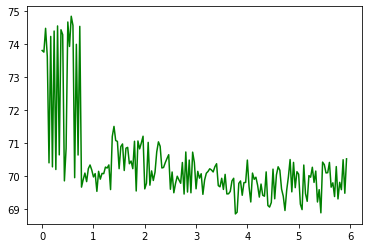

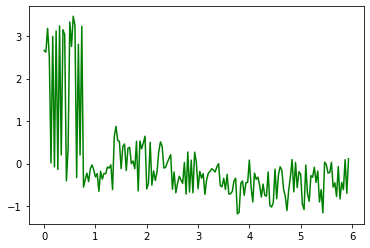

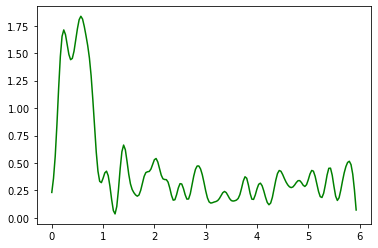

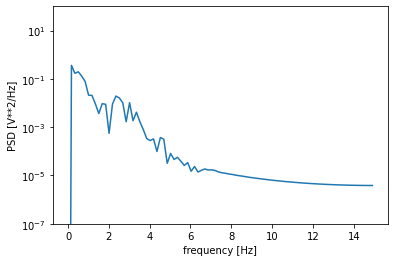

0.16759776536312848


In [34]:
a = np.asarray(color_sig)
red = a[:,0]
green = a[:,1]
blue = a[:,2]
print(green)
x = np.arange(green.size/fps,step= (1/30))
plt.plot(x,green,color ='green')
plt.show()


green = green - np.mean(green)
green = green / np.std(green)
plt.plot(x,green,color ='green')
plt.show()

g = filter_channel(green,round_fps)


plt.plot(x,g,color ='green')
plt.show()

f, Pxx_den = sig.periodogram(g, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

max_val = Pxx_den.argmax()
print(f[max_val])


In [ ]:
window_time_sec = 1
window_size = int(np.ceil(window_time_sec * round_fps))

window_start = color_sig.shape[1]
while window_start > window_size :
    window_start -= window_size
    window = color_sig[window_start : window_start + window_size]
    last_hr = heart_rates[-1] if len(heart_rates) > 0 else None
    heart_rates.append(getHeartRate(window))

In [ ]:
getHeartRate(color_sig)

In [ ]:
if frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [ ]:
### PSD estimation using 'Welch' or 'Periodogram'


In [ ]:
window_time_sec = 1
window_size = int(np.ceil(window_time_sec * round_fps))

window_start = color_sig.shape[1]
while window_start > window_size :
    window_start -= window_size
    window = color_sig[window_start : window_start + window_size]
    last_hr = heart_rates[-1] if len(heart_rates) > 0 else None
    heart_rates.append(getHeartRate(window))

In [ ]:
getHeartRate(color_sig)

In [ ]:
if frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'


In [ ]:
#flattop
# Welch method:
f, Pxx_den = sig.welch(green_buttered, round_fps,'hamming', 1024, scaling='spectrum')

### Plot final results

In [ ]:
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# periodogram method:
f, Pxx_den = sig.periodogram(green_buttered, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()